## Fake or Real News Classification using Logistic Regression

Bu projede, haber metinlerinin sahte mi yoksa gerçek mi olduğunu sınıflandırmak için **TF-IDF** yöntemi ile metin vektörleştirme yapılmış ve ardından **Lojistik Regresyon** modeli uygulanmıştır.

Proje kapsamında:

- Kaggle'dan alınan dengeli bir veri kümesi kullanılmıştır.
- Modelin başarımı `Accuracy`, `Precision`, `Recall`, `F1-score` ve `ROC AUC` gibi metriklerle değerlendirilmiştir.
- `GridSearchCV` ile model parametreleri optimize edilmiştir.
- Rastgele seçilen haberler üzerinde modelin tahmini test edilmiştir.

Bu notebook, gözetimli öğrenme (supervised learning) yaklaşımıyla NLP alanında temel bir metin sınıflandırma uygulamasını kapsamaktadır.

## GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ

Bu hücrede, veri analizi (Pandas, NumPy), görselleştirme (Matplotlib, Seaborn) ve makine öğrenmesi için gerekli Scikit-learn kütüphaneleri import edilmektedirAyrıca metin verilerini sayısal forma dönüştürmek için TfidVectorizer kullanılacaktır..


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,roc_auc_score,roc_curve,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

## VERİ SETİNİN YÜKLENMESİ

Haberlerin sahte mi gerçek mi olduğunu içeren veri seti CSV formatında içe aktarılmaktadır..


In [53]:
df=pd.read_csv("news_datasets.csv")

## VERİ SETİNİN İLK 5 SATIRI


Veri setinin genel yapısını görmek amacıyla ilk 5 satır görüntülenmektedirBu adımda veri sütunları (title,text,label) incelenir.


In [54]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## GEREKSİZ SÜTUNUN TEMİZLENMESİ

CSV dosyası yüklenirken oluşan `Unnamed: 0` adlı index sütunu analiz için gereksiz olduğundan kaldırılmıştır.

In [55]:
df = df.drop(columns=['Unnamed: 0'])

## VERİ SETİNİN YAPISI

Bu komut kullanılarak veri setinin sütunlarırı, veri tipi ve boş değer kontrolü yapılmışt.3 sütunlu ve 6335 satırlı bir veri seti ile çalışılmaktadır.


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


## EKSİK DEĞER KONTROLÜ

Her sütundaki eksik değer sayısı hesaplanarak veri temizliği açısından kontrol edilmiştir.

In [57]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

## VERİ SETİNİN BOYUTU

Veri setinin satır ve sütun sayısı incelenmiştir. Bu veri seti 6335 satır ve 3 sütun içermektedir

In [58]:
df.shape

(6335, 3)

In [59]:
print(df['label'].value_counts())

label
REAL    3171
FAKE    3164
Name: count, dtype: int64


## ETİKET DAĞILIMININ İNCELENMESİ

Sahte ve gerçek haberlerin dağılımı hem sayısal hem de oran olarak analiz edilmiştir. Veri seti dengelidir, bu da modelleme için avantajlıdır

In [60]:
df['label'].value_counts(normalize=True)

label
REAL    0.500552
FAKE    0.499448
Name: proportion, dtype: float64

## ETİKETLERİN SAYISALLAŞTIRILMASI

Sınıflandırma modeliyle çalışabilmek için "FAKE" etiketi 1'e, "REAL" etiketi 0'a dönüştürülmüştür

In [61]:
df['label'] = df['label'].map({'FAKE': 1, 'REAL': 0})

## DÖNÜŞTÜRÜLMÜŞ VERİNİN SON HALİ

Sayısal etiketlerin veri setine başarılı şekilde yansıyıp yansımadığı kontrol edilmiştir

In [62]:
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


## BAĞIMLI DEĞİŞKENİN TANIMLANMASI

Modelin hedef değişkeni olan etiketler y olarak ayrı bir değişkene atanmıştır 

In [63]:
y=df["label"]

## BAŞLIK VE İÇERİĞİN BİRLEŞTİRİLMESİ

Modelin daha iyi öğrenebilmesi için haberin başlığı ve içeriği birleştirilerek tek bir metin sütunu oluşturulmuştur

In [64]:
df['combined'] = df['title'] + " " + df['text']

## METİN VERİSİNİN SAYISALLAŞTIRILMASI

Birleştirilen metin sütunu, TF-IDF yöntemiyle sayısal forma dönüştürülmüştür. "stop_words=english" ve "max_df=0.7" parametreleri ile sık geçen kelimeler elenmiştir

In [65]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['combined'])

## EĞİTİM VE TEST VERİSİNİN AYRILMASI

Veri setinin %80'i eğitim, %20'si test için ayrılmıştır. "random_state=64" sabitlenerek aynı bölünmenin tekrarlanabilir olması sağlanmıştır

In [66]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=64)

## LOJİSTİK REGRESYON MODELİNİN EĞİTİMİ

Veri setinin eğitim kısmı ile Lojistik Regresyon modeli eğitilmiş, test verisi üzerinden tahmin yapılmıştır.
"predict_proba" fonksiyonu ile her sınıfa ait olasılıklar elde edilmiştir


In [67]:
model=LogisticRegression().fit(X_train,y_train)

In [68]:
y_pred=model.predict(X_test)
y_prob=model.predict_proba(X_test)[:,1]

## SINIFLANDIRMA RAPORU VE ROC-AUC DEĞERİ

Presicion,recall, f1-score gibi metrikleri içeren genel sınıflandırma raporu elde edilmiştir. Ayrıca modelin ROC-AUC değeri hesaplanarak genel ayrım gücü ölçülmüştür

In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       649
           1       0.88      0.95      0.91       618

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



In [70]:
roc_auc_score(y_test,y_prob)

0.9766057813614174

## KARMAŞIKLIK MATRİSİ

Modelin doğru ve yanlış sınıflandırmalarının sayısal olarak gösterildiği karmaşıklık matrisi çizilmiştir

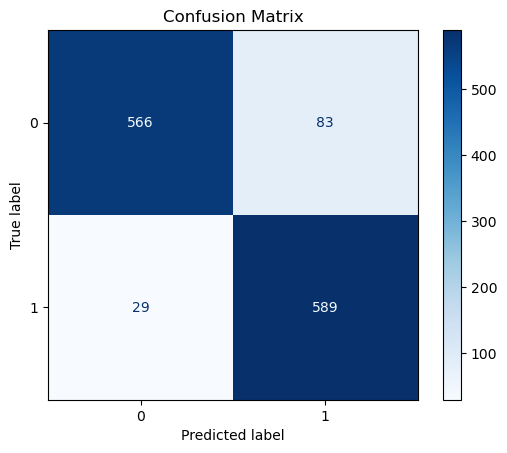

In [71]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## MODELİ RASTGELE BİR HABER ÜZERİNDE TEST ETME

Veri setinden rastgele bir haber seçilerek metni ve FAKE mi yoksa REAL mı olduğunu gösteren etiketi görüntülenmiştir. Bu adım, modelin gerçek dünyada nasıl performans göstereceğini gözlemlemek için faydalıdır

In [113]:
random_news = df.sample(1, random_state=random.randint(0, 10000))
print("Metin:\n", random_news['combined'].values[0][:500], "... [devamı]")
print("Etiket:", random_news['label'].values[0]) # FAKE : 1 , REAL : 0 

Metin:
 Re: Don’t CLICK that, stupid! Is this email from March 2016 where #PodestaEmails21 and others started? Don’t CLICK that, stupid! Is this email from March 2016 how ‘hackers’ accessed #PodestaEmails21 and others? Posted at 11:22 am on October 28, 2016 by Sam J. Share on Facebook Share on Twitter 
Baby Boomers and the Interwebz. 
Dear John and other people who have been living under a rock, Google wouldn’t send you an email called, “Someone has your password.” Likely it would be a message about a p ... [devamı]
Etiket: 1


## CROSS VALİDATİON İLE PERFORMANS DEĞERLENDİRMESİ

10 katlı çapraz doğrulama uygulanarak modelin accuracy,recall,precision ve f1-score'u değerlendirilmiştir

In [73]:
cv_results=cross_validate(model,X,y,cv=10,scoring=["precision","recall","accuracy","f1"])

In [74]:
cv_results

{'fit_time': array([0.20957637, 0.18358231, 0.18089056, 0.18690348, 0.15738034,
        0.17039347, 0.20266581, 0.24138069, 0.16052938, 0.16403747]),
 'score_time': array([0.0041554 , 0.00581861, 0.0040915 , 0.00822973, 0.00404382,
        0.00463295, 0.0091958 , 0.00820398, 0.00409532, 0.00820351]),
 'test_precision': array([0.90634441, 0.87142857, 0.88046647, 0.8914956 , 0.92      ,
        0.89253731, 0.92      , 0.90461538, 0.89020772, 0.90461538]),
 'test_recall': array([0.94637224, 0.96214511, 0.95268139, 0.95899054, 0.94620253,
        0.94620253, 0.94620253, 0.93037975, 0.94936709, 0.93037975]),
 'test_accuracy': array([0.92429022, 0.91009464, 0.91167192, 0.92113565, 0.93217666,
        0.91627172, 0.93206951, 0.91627172, 0.91627172, 0.91627172]),
 'test_f1': array([0.92592593, 0.91454273, 0.91515152, 0.92401216, 0.93291732,
        0.91858679, 0.93291732, 0.91731669, 0.91883614, 0.91731669])}

In [75]:
cv_results["test_accuracy"].mean()

0.9196525483277769

In [76]:
cv_results["test_recall"].mean()

0.946892345166314

In [77]:
cv_results["test_precision"].mean()

0.8981710853578069

In [78]:
cv_results["test_f1"].mean()

0.9217523276931322

In [79]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## HİPERPARAMETRE AYARI (GRİDSEARCHCV)

Lojistik Regresyon modelinin en iyi parametrelerini bulmak için GridSearchCV uygulanmıştır. 'penalty','C','max_iter' gibi hiperparametreler optimize edilmiştir

In [80]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # l1 için lbfgs desteklemez!
    'max_iter': [100, 200],
    'class_weight': [None, 'balanced']
}

In [81]:
best_grid=GridSearchCV(model,param_grid,cv=10,n_jobs=-1,verbose=1).fit(X_train,y_train) 

Fitting 10 folds for each of 32 candidates, totalling 320 fits


In [82]:
best_grid.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [83]:
best_grid.best_score_

0.9337013042698661

## FİNAL MODELİNİN EĞİTİLMESİ VE PERFORMANS ÖLÇÜMÜ

GridSearchCV sonucu elde edilen en iyi parametreler ile final modeli yeniden eğitilmiştir

In [84]:
final_model=LogisticRegression(**best_grid.best_params_,random_state=64).fit(X_train,y_train)

In [87]:
y_prob_final = final_model.predict_proba(X_test)[:, 1]

## ROC EĞRİSİ VE AUC SKORU

Bu hücrede, final modelin sınıflandırma performansı, ROC eğrisi üzerinden görselleştirilmiştir. ROC eğrisi, modelin farklı eşik değerlerindeki "True Positive Rate (Duyarlılık)" ve "False Positive Rate (Yanlış Pozitiflik)" oranlarını karşılaştırır. 
Eğrinin altındaki alan olan AUC skoru, modelin sınıflar arasında ne kadar iyi ayrım yapabildiğini ölçer

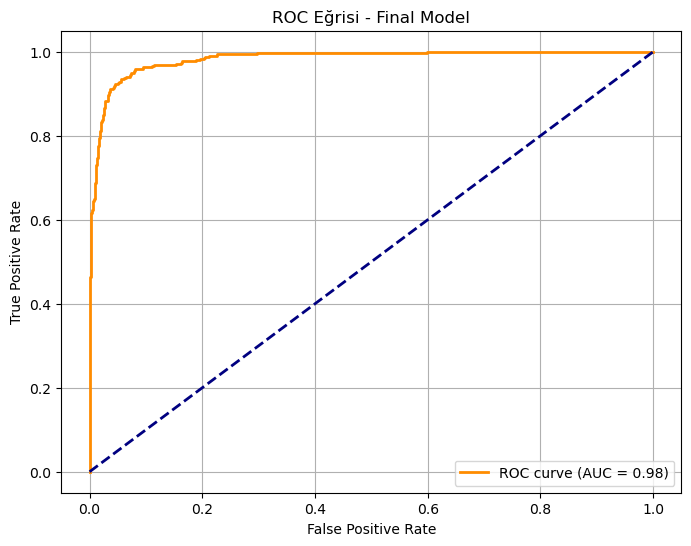

📈 AUC Skoru: 0.9827


In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_final)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi - Final Model')
plt.legend(loc="lower right")
plt.grid()
plt.show()
print(f"📈 AUC Skoru: {roc_auc:.4f}")

In [89]:
final_model.get_params()

{'C': 10,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 64,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [90]:
final_model=final_model.set_params(**best_grid.best_params_).fit(X_train,y_train)

In [74]:
cv_results=cross_validate(final_model,X,y,cv=10,scoring=["f1","roc_auc","accuracy"])

In [75]:
cv_results["test_f1"].mean()

0.9399029401177804

In [76]:
cv_results["test_roc_auc"].mean()

0.9832719095692758

In [77]:
cv_results["test_accuracy"].mean()

0.9389108994772277

## FİNAL MODELİ İLE RASTGELE HABER ÜZERİNDE TAHMİN

Son model ile, rastgele seçilen haberin FAKE mi yoksa REAL mı olduğu gözlemlenmiştir

In [111]:
random_news = df.sample(1, random_state=random.randint(0, 10000))
vec = vectorizer.transform(random_news['combined'])
predicted_label = final_model.predict(vec)[0]

In [112]:
print("Metin:\n", random_news['combined'].values[0][:500], "... [devamı]")
print("Gerçek Etiket:", "FAKE" if random_news['label'].values[0] == 1 else "REAL")
print("Model Tahmini:", "FAKE" if predicted_label == 1 else "REAL")

Metin:
 part 38 “Impossible” statues, “Impossible” ancient jewellery, Moscow nuked, “Impossible” steel [VIDEO] Click Here To Learn More About Alexandra's Personalized Essences Psychic Protection Click Here for More Information on Psychic Protection! Implant Removal Series Click here to listen to the IRP and SA/DNA Process Read The Testimonials Click Here To Read What Others Are Experiencing! Copyright © 2012 by Galactic Connection. All Rights Reserved. 
Excerpts may be used, provided that full and clear ... [devamı]
Gerçek Etiket: FAKE
Model Tahmini: FAKE
